In [4]:
%cd ..

/home/mounim/PHD-Projects/GES


In [5]:
#pip install matplotlib numpy pandas seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns
import random
import sys
from itertools import combinations
import scipy.cluster.hierarchy as shc
from Bio.pairwise2 import format_alignment
from src import dataset_simulator
import networkx as nx



In [2]:
5000 * 0.001

5.0

In [6]:
## Binary tree
### N generations
id = "binomial_dataset"
L = 5000 # len of sequence
mutation_rate = 0.001
generations = 4 # N = g!
random_sequence = dataset_simulator.generate_random_seq(L) #sequence of lenght L

# make binary dataset 
simulated_dataset = dataset_simulator.make_binray_tree(random_sequence, generations = generations, mutation_rate = mutation_rate, mutation_types='S', distribution = 'binomial')

dataset_simulator.dict_to_fasta(simulated_dataset , './data/simulation_dataset/' , filename = id)


In [7]:

from Bio import pairwise2
from Bio import Align

# 1. pairwise align
id = "binomial_dataset"
path = './data/tmp/'

simulated_dataset = {}
f = open('./data/simulation_dataset/' + id + '.fasta', 'r').read().split('\n')
i = 0
while i + 1 < len(f) :
    simulated_dataset[f[i].replace('>','')] = f[i+1]
    i+=2
ids = list(simulated_dataset)
ids
scores = []
score_matrix = pd.DataFrame(np.zeros((len(ids),len(ids))))
score_matrix.index = ids
score_matrix.columns = ids
while len(ids) > 1:
    id_ref = ids.pop(0)
    ref = simulated_dataset[id_ref]
    for id_tar in ids:
        tar = simulated_dataset[id_tar]
        # print(len(ref), len(tar))
        score = dataset_simulator.needle_align_code(ref, tar)
        # print(id_ref , id_tar , score, len(ref), len(tar))
        scores.append([id_ref, id_tar, score ])  #add to the end

scores_df = pd.DataFrame(scores)  
# print(scores_df)


for s in scores:
    score_matrix.loc[s[0] , s[1]] = 100 - float(s[2])
    score_matrix.loc[s[1] , s[0]] =  100 - float(s[2])
score_matrix

KeyboardInterrupt: 

## KNN

In [6]:
import pandas as pd
import numpy as np

edges = []

X = score_matrix
# X = X.T
k = 3
for i in X.index:

    Y = X.nsmallest(k, i)
    Y = Y.T
    Y = Y[Y.index.str.startswith(i)]
    Y = Y.loc[:, Y.any()]

    for j in Y.index:
        # print(i + ": ", list(Y.columns))
        for c in list(Y.columns):
            edges.append([i, c])


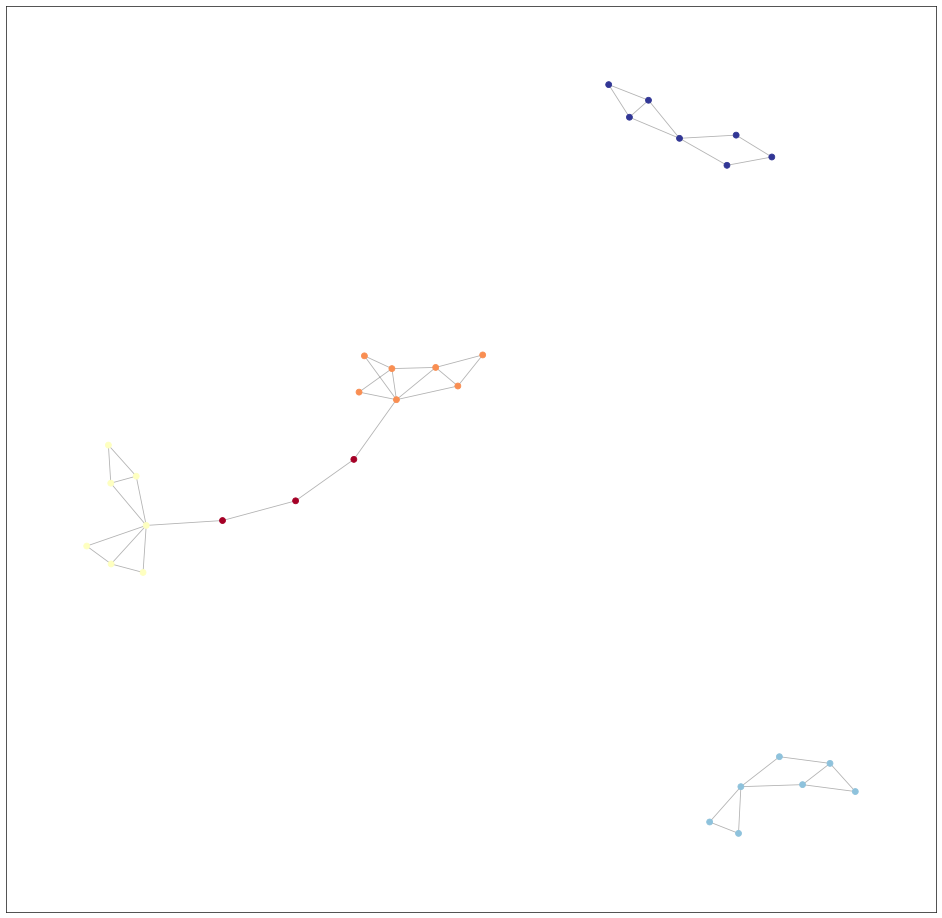

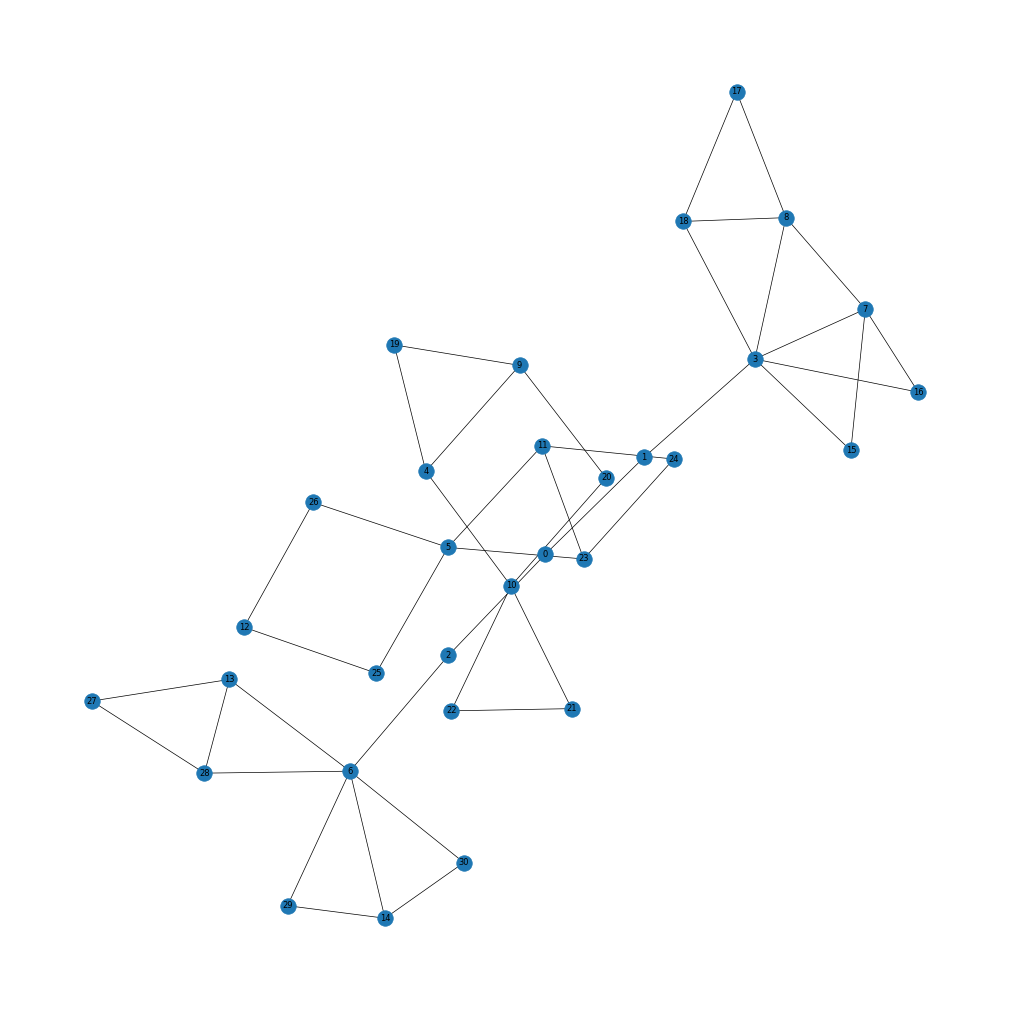

In [7]:
import community.community_louvain as com
 
Edges = pd.DataFrame(edges)
id_map = {}
i = 1
names = set( Edges[1] ) | set( Edges[0] ) 
for id in names:
    id_map[id] = str(id).split('N')[1]
    i+=1
id_map
edgelist = Edges.replace({0 : id_map, 1 : id_map} )
edgelist.columns = ['source','target']

meta = []
for id in names:
    N = str(id).split('N')[1]
    Gen = str(id).split(':')[0].replace('Gen','')
    seq = simulated_dataset[id]
    meta.append([Gen,N, seq])
meta = pd.DataFrame(meta, columns=['Gen','N', 'seq'])


fig = plt.figure(1, figsize=(20, 20), dpi=60)
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist)
partition = com.best_partition(G)  # compute communities
pos = nx.spring_layout(G)  # compute graph layout
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

fig = plt.figure(1, figsize=(20, 20), dpi=50)
nx.draw_kamada_kawai(G, with_labels=True, node_size=500)

In [8]:
# import matplotlib.pyplot as plt
# import networkx as nx
# import pydot
# from networkx.drawing.nx_pydot import graphviz_layout

# T = nx.balanced_tree(2, 6)

# pos = graphviz_layout(T, prog="twopi")
# fig = plt.figure(1, figsize=(20, 20), dpi=50)
# nx.draw(T, pos)
# plt.show()

In [9]:
# combine edgelist and meta to add date
meta.columns = ['source_gen','source','seq_ref']
conneted_sequences = pd.merge(meta, edgelist)
meta.columns = ['target_gen','target','seq_tar']
conneted_sequences = pd.merge(meta, conneted_sequences)
conneted_sequences['gen_dif'] = abs(conneted_sequences['source_gen'].astype(int) - conneted_sequences['target_gen'].astype(int))
conneted_sequences = conneted_sequences.loc[conneted_sequences.gen_dif != 0,:]
# conneted_sequences
conneted_sequences = conneted_sequences.reset_index()


In [10]:
vars_all  = pd.DataFrame()
mut_rate  = []
for pair in conneted_sequences.iterrows() :
    sr = pair[1][3]
    st = pair[1][6]
    alignments = pairwise2.align.globalms(sr, st, 5, -4, -3, -.1)
    alignment = format_alignment(*alignments[0]).split('\n')
    ref_bases = [char for char in alignment[0]] 
    tar_bases = [char for char in alignment[2]] 
    pos = [ i for i in range(len(alignment[2])) ]
    vars = [ref_bases, tar_bases, pos]
    vars = pd.DataFrame(vars).T
    vars.columns = ['ref','tar','pos']
    vars = vars.loc[vars.ref != vars.tar ,:]
    vars.to_csv( "./data/align/" + str( str(pair[1][1]) + str(pair[1][4]) ) )
    vars_all = vars_all.append(vars) 
    mut_rate.append([vars.shape[0] , pair[1][7]])

vars_all.to_csv( './data/'+id+'vars_all.csv')
mut_rate = pd.DataFrame(mut_rate, columns=['x','y'])
mut_rate.to_csv( './data/'+id+'mut_rate.csv')

/tmp/ipykernel_659261/398749817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_659261/398749817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_659261/398749817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_659261/398749817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vars_all = vars_all.append(vars)
/tmp/ipykernel_659261/398749817.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(56,) (56,)
111.40178571428571
coef [[0.01868455]]


/tmp/ipykernel_659261/3847424131.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  mut_rate.r =  mut_rate.x / mut_rate.y


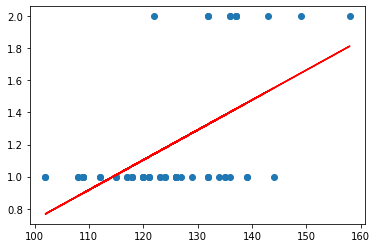

In [11]:
from sklearn import linear_model

# load dataset
x, y = mut_rate.x , mut_rate.y
# summarize shape
print(x.shape, y.shape)
# scatter plot of input vs output

mut_rate.r =  mut_rate.x / mut_rate.y
print(mut_rate.r.mean())

x = np.array(mut_rate[["x"]])
y = np.array(mut_rate[["y"]])


regr = linear_model.LinearRegression()
regr.fit(x, y)
# predictedCO2 = regr.predict([[2300, 1300]])

n_geners = 3
test = np.array([n_geners]).reshape(1, 1)
n_mut_predicted = regr.predict(test)
n_mut_predicted[0][0]
print('coef', regr.coef_)

plt.scatter(x, y)
plt.plot(x, regr.predict(x), c = 'r')
#x


0.00950135321691545


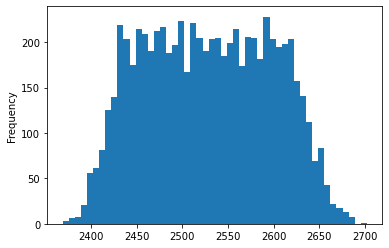

In [12]:

mut_rate.r =  mut_rate.y / mut_rate.x 
print(mut_rate.r.mean())

vars = vars_all
ax = vars.pos.plot(kind='hist',bins = 50)

# predict next position (fiting model to vars_all)

In [45]:
import scipy
import numpy as np

# fit to var_1 (pos)
mu, std = scipy.stats.norm.fit(np.array(vars_all['pos'], dtype=int) )
predicted_pos = np.random.normal(mu, std, size=1 )
predicted_pos # predict pos

array([519.47442762])

# predict next mutation

In [46]:
seq0 = meta.iloc[0,2] # to mutate : select from data set
seq0

'ACCCGACGAATTTTAAATTAACCAACAGTCACATTCCAACCAGTGGCAAAACCTTATGCTACGTGCGGGTCATAGTCATTTGCTGCTTCGCTGCGTGGGTTAACGCGCCACTGTTCAAAATGGTTAGGGAGGCCATGCGTTCTAGCGTTCCGGCCTTTGTCGGGTGGCTTTTCTCGTCCACCCCACCCCTAAACCCCCACCCCCTAACATGCGTCCTCACGCCAATCTAGAGCCCGTGGAATAGGAGCATTCACAGCTCCTTCCATGTCCAGTCGAATCTATCGCGATACGCTATCGGTCCAGTGGCCATTATGCCGGGAATTCCGCCTGACACGATTCGTTTGATGGTGGTAAAAGCTTTGGGATGTTTAAGACTACCTAGGGATCCAAGACCGTAGCACTTCATGTTTGGTCGACCCTCGTGCATGTGGCCGGTCATTTAGGAACGGTCTACTCTGGATGTCTCTCTTGGCGCGGTCTATGTTCGGGCAAAGCGGTGCTGATCTTCTGAACGCTATCCGTGTGTTAGTACAGATAGCGCCCATCCGCGGGGTAATGTAGGCCCTATTGATGTTAGATAGGCGAATACCCTAAATTGAGCGCTGGCATCAACTATGAATGTCCTCGCATTATCGTTAGCTGCCTTTTGTCTCTACTCCGATCTTTCTATAGTGATAACGTTCTGTGTCTCACCCATTGGTCATGTTGTCAACCGCCCACGCCTACGTGGTTCCAGTTGCCGCGATGAGCGTTGGTCCTCATCTGGGGATTACAGCAAAGTCTGCTCTGGTTACATCCGAGACTAGATCCTACTCCGTCGGCAAGGTCTTTCTGAGGGTGGGCCCGGGGCTTCCGGATGGATCACTAGTTCCCTACCCGACTTTCATAAGCGGTCTCTTCGCCCATCACATCATCAAGGGTCGGCGGGCTCCTCATTTCTTCACAGAGGCTTCCTCGCGTAAGGGCGTTTATAATCACTAACTTACCACCTCCGCCGTG

In [59]:
mapping = {'A':0,'C':1,'G':2,'T':3,'-':4}
Vars_all = vars_all.replace({'ref': mapping, 'tar': mapping})
Vars_all

,ref,tar,pos
480,0,2,480
484,4,0,484
486,3,4,486
509,3,2,509
529,2,3,529
...,...,...,...
494,0,4,494
496,4,0,496
504,3,2,504
512,0,3,512


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = Vars_all.iloc[:,[0,2]]
y = Vars_all.tar

randomforest = RandomForestClassifier()
randomforest.fit(X, y)
X_test = pd.DataFrame([[0,5],[0,50],[0,1100],[0,8]])
X_test.columns=['ref','pos']
####
y_pred = randomforest.predict(X_test)
y_pred

array([3, 3, 3, 3])